In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            cohort_dist[x,y]=scipy.spatial.distance.jensenshannon(p=np.array(i), q=np.array(j))
            
            y=y+1
        y=0
        x=x+1
    return cohort_dist

def plot_KLD(cohort_dist,age_labels,vmin=0.1,vmax=0.1,title='distance'):
    # cohort_dist is matrix of
    seqmatcolor='cubehelix'
    cmg=sns.clustermap(cohort_dist,cmap=seqmatcolor,
                       xticklabels=1,
                       yticklabels=1,
                   colors_ratio=0.2,cbar_pos=(1.05, 0.045, 0.03, 0.75),
                   col_cluster=False,row_cluster=False,
                   method='average',metric='sqeuclidean', vmin=vmin,vmax=vmax)
    cmg.fig.set_size_inches(6,6)
    ax = cmg.ax_heatmap
    ax.set_xticklabels(age_labels, fontsize=6)
    ax.set_yticklabels(age_labels)
    ax.set_title(title,fontsize=14)
    plt.show()

In [5]:
## update data
def remove_crl(df):
    max=39
    df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [6]:
# arrange data
# pseudo data males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_pseudotime_v02.parquet')
m_psd = pd.read_parquet(path)
m_psd=m_psd.reset_index()
m_psd=m_psd[['uuid','pseudotime_rank','age']]

#make sure only animals in clean v2 are in the male dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_v2.parquet')
df_males = pd.read_parquet(path)
df_males = remove_crl(df_males)
m_psd = df_males.merge(m_psd, on='uuid', how='left')

#do some cleaning up
m_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
m_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
m_psd = m_psd.filter(regex=r'\d')

## convert male pseudotime to bins and remap the bins
m_psd['bins'] = pd.qcut(m_psd.index.get_level_values('psd'), len(m_psd.index.get_level_values('age').unique()),labels=False)

ages = m_psd.index.get_level_values('age').unique().to_numpy()
mapdr_males = dict(zip(list(range(len(ages))), ages))
y_temp = m_psd['bins'].to_numpy()
y_temp = [mapdr_males[item] for item in y_temp]

m_psd['remapped_bins'] = y_temp
m_psd.set_index(['bins','remapped_bins'], 
                append=True, inplace=True)

In [7]:
m_psd

,,,,,,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
,psd,uuid,age,bins,remapped_bins,,,,,,,,,,,,,,,,,,,,,
0,0.055749,8e6b7f38-4f76-4307-81b2-129dc9016853,3,0,3,0.069469,0.011115,0.004168,0.001042,0.012157,0.010420,0.022230,0.031608,0.007642,0.005557,...,0.014588,0.024314,0.026745,0.050712,0.042028,0.002431,0.031261,0.007642,0.012157,0.012504
1,0.202091,2b5a857f-2e64-470c-801e-1149450c6f56,3,3,9,0.053075,0.020833,0.011409,0.009425,0.013641,0.013641,0.031994,0.013889,0.016121,0.013889,...,0.013393,0.020585,0.013393,0.050347,0.038194,0.006944,0.013889,0.014137,0.008681,0.005704
2,0.027875,8a69a400-d4c6-4e3a-a1ce-90fd44e2b211,3,0,3,0.089396,0.005429,0.005067,0.000362,0.014115,0.005791,0.022077,0.024611,0.004705,0.000724,...,0.012667,0.012305,0.038726,0.020992,0.049946,0.003981,0.024973,0.016649,0.013029,0.010496
3,0.052265,4c88ce4e-4ba7-4c6b-84f6-b979c71e2439,3,0,3,0.058875,0.012824,0.007287,0.002040,0.009327,0.017196,0.016613,0.025357,0.010784,0.011075,...,0.008161,0.037015,0.009618,0.028855,0.055960,0.002915,0.040222,0.024774,0.005246,0.011950
4,0.020906,e953b275-d126-4a37-888a-7df0af565c0a,3,0,3,0.079073,0.011247,0.009884,0.001363,0.010566,0.016360,0.016019,0.022836,0.009884,0.007157,...,0.010225,0.024881,0.044308,0.027948,0.056237,0.004772,0.020450,0.023517,0.009543,0.012952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,0.982578,7a5f5257-fd29-4451-9680-b2cee905c337,90,17,90,0.023407,0.026287,0.083543,0.033489,0.056536,0.021246,0.001440,0.009003,0.077782,0.039971,...,0.012964,0.000000,0.003241,0.000000,0.000000,0.017285,0.005041,0.027728,0.032769,0.002521
282,1.000000,b7b7dfa0-66e1-4f48-a118-2fec4b8ce144,90,17,90,0.026862,0.030086,0.078080,0.037249,0.030802,0.023997,0.000358,0.012178,0.116404,0.070917,...,0.008954,0.000000,0.001791,0.000000,0.000358,0.010029,0.001433,0.037607,0.008954,0.004656
283,0.986063,e272b7f4-3fe2-4fba-8ae9-0b1f8da43f69,90,17,90,0.013029,0.060442,0.087948,0.055375,0.039812,0.017010,0.000000,0.010496,0.119073,0.082519,...,0.008324,0.000000,0.000724,0.000000,0.000000,0.010134,0.000362,0.021716,0.005067,0.011582


In [8]:
data = m_psd.copy()
data= data.groupby(['psd','uuid','age']).mean().filter(regex=r'\d')
data_labels = data.index.get_level_values(0).to_numpy()

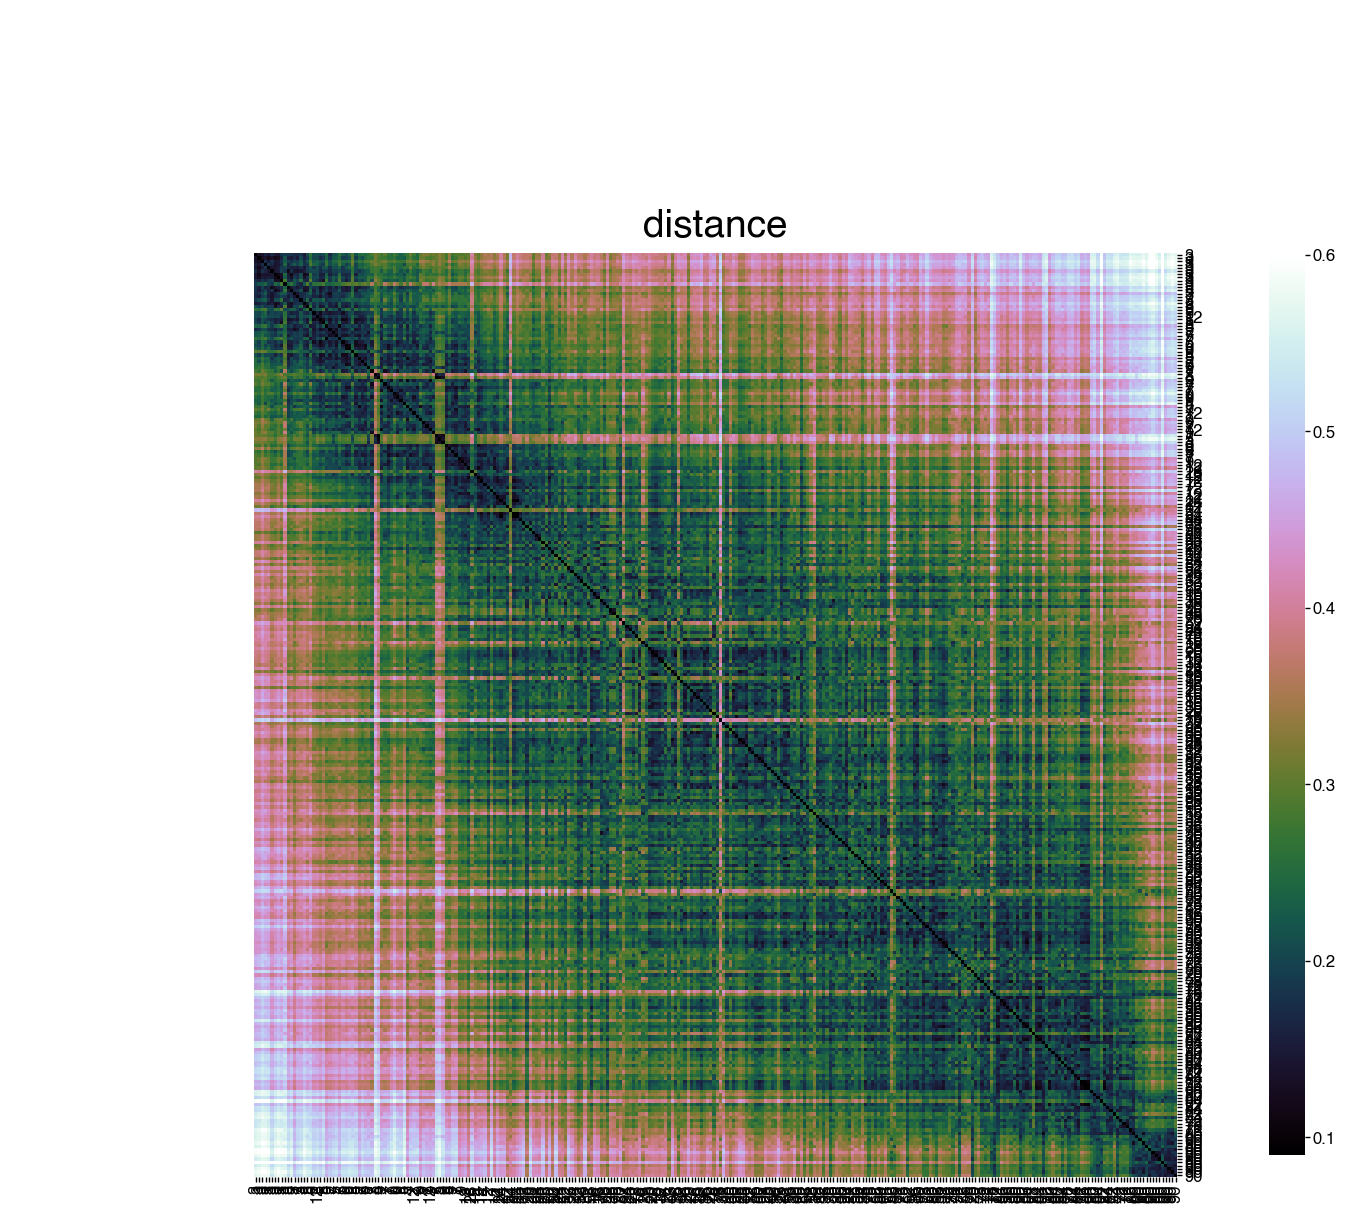

In [9]:
kld = KLD_analysis(data.to_numpy())
plot_KLD(kld,data.index.get_level_values('age'),0.6)

In [10]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

<Figure size 1200x1200 with 0 Axes>

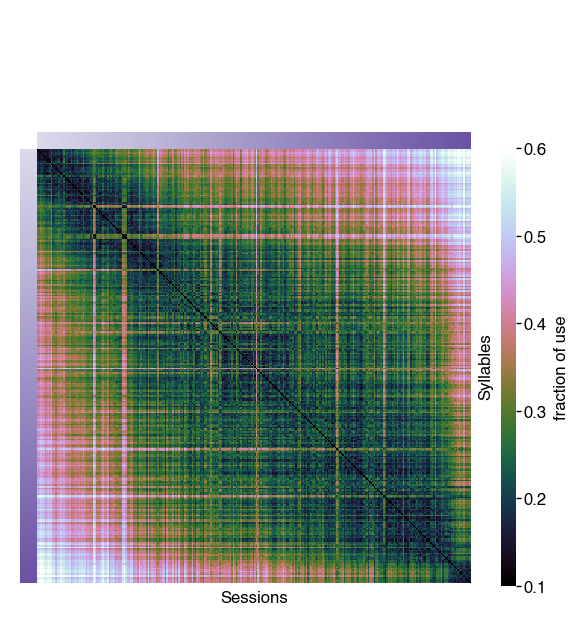

In [11]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=kld,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.1,
    vmax=0.6)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
plt.show()

In [12]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig2"/ 'F_dist_psd_jsd.pdf', bbox_inches='tight')

In [13]:
from sklearn.metrics import pairwise_distances
utemp = pairwise_distances(data.to_numpy())
ctemp = pairwise_distances(data.to_numpy(), metric = 'cosine')

<Figure size 1200x1200 with 0 Axes>

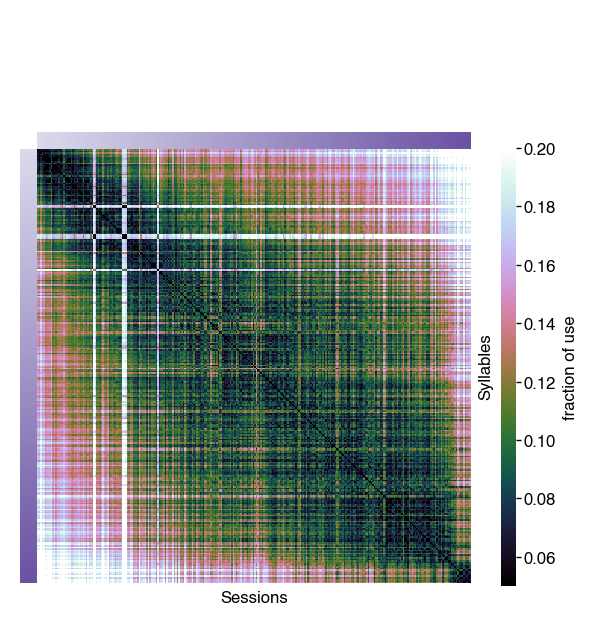

In [14]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=utemp,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    #metric='sqeuclidean',
    metric='cosine',
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.05,
    vmax=0.2)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
plt.show()

In [15]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig2"/ 'F_dist_psd_euc.pdf', bbox_inches='tight')

<Figure size 1200x1200 with 0 Axes>

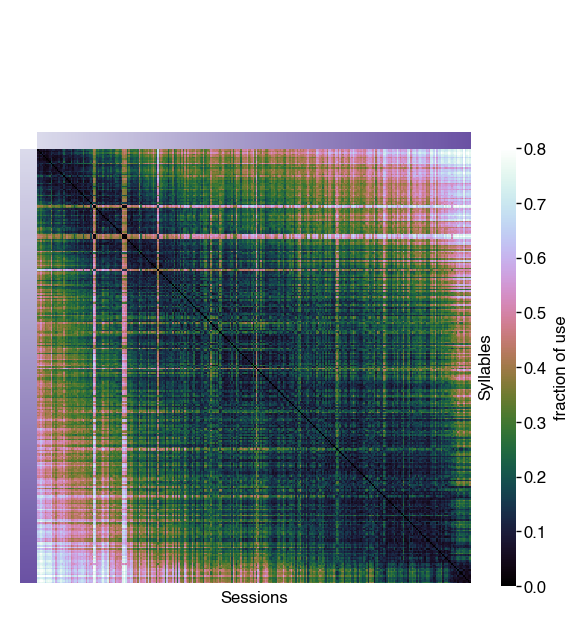

In [16]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=ctemp,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    #metric='sqeuclidean',
    metric='cosine',
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.8)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
plt.show()

In [17]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig2"/ 'F_dist_psd_cosine.pdf', bbox_inches='tight')